## Quantitatively analysis the results from JDDC and compare to ground truth
The goal of this notebook is to test whether JDDC can recover the quantitative information from noisy image series using simulated data

In [11]:
import os
import scipy.io as sio
import scipy.misc as smisc
import numpy as np
import re as regexp
import math
import matplotlib.pyplot as plt
import scipy

import scipy.io
import time
import glob,os
from scipy import optimize
from pylab import *
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

import csv
import struct
import bz2
from scipy import integrate

In [129]:
path = 'E:/JDDC/DoseTest_sim/0.5us_0.5flyback/10Frames/'
list_2 = glob.glob(path + '10Frames*/')
prec_x_list = np.zeros((len(list_2),1))
prec_y_list = np.zeros((len(list_2),1))
count = 0
j = 0
# for j in range(len(list_2)):
path_final = list_2[j]
csvfile = path_final + 'bump-0_003-centers.csv'
txtfile = path_final + 'bump-0_003.txt'

IndexError: list index out of range

In [190]:
txtfile = 'E:/JDDC/DoseTest_sim/10.0us_0.25flyback/10Frames/10Frames_B1_results/bump-0_003.txt'

In [191]:
# read all the peak information from bump-0_003.txt file
f = open(txtfile, "r")
length = len(f.readlines())
f.close()
nsites = int((length-4)/3)
f = open(txtfile,"r")
x_list = []
y_list = []
int_list = []

for isite in range(nsites):
    x_cor = float(f.readline())
    y_cor = float(f.readline())
    if x_cor > 15 and x_cor < 135 and y_cor > 15 and y_cor < 135:
        x_list.append(x_cor)
        y_list.append(y_cor)
        int_list.append(float(f.readline()))
    else:
        f.readline()

sigma_x = float(f.readline())
sigma_y = float(f.readline())
cor = float(f.readline())
I0 = float(f.readline())

f.close()

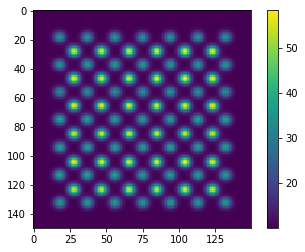

In [188]:
fitting = np.zeros((150,150))
for i in range(len(x_list)):
    fitting = fitting + AsyGaussian(150, 150, 0, cor, sigma_x, sigma_y, x_list[i], y_list[i], int_list[i] )
fitting = fitting + I0
plt.imshow(fitting)
plt.colorbar()

In [217]:
# Calculate integrated intensity for each peak
integrated_int_list = []
for isite in range(len(x_list)):
    integrated_int_list.append(GaussianIntegration(I0,cor,sigma_x, sigma_y, int_list[isite],5)[0])

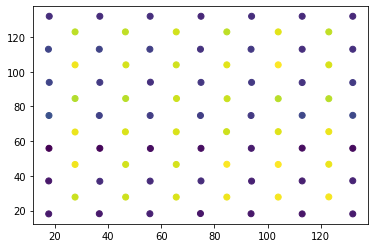

In [218]:
plt.scatter(x_list,y_list,c=integrated_int_list)

In [219]:
# Load ground truth and do Gaussian fitting
truth = LoadQ2('E:/JDDC/DoseTest_sim/10.0us_0.25flyback/Data/STO_Truth.q2')
# plt.imshow(truth)
img = truth[0:150,0:150]
image_max = ndi.maximum_filter(img, size=10, mode='constant')
coordinates = peak_local_max(img, min_distance=7)
# plt.imshow(img)
# plt.scatter(coordinates[:,0],coordinates[:,1])

peaks_x_fit = []
peaks_y_fit = []
integrated_int_truth = []

for i in range(coordinates.shape[0]):

    x = int(coordinates[i][1])
    y = int(coordinates[i][0])
    if x >=7 and y>=7:
        patch = img[y-6:y+6,x-6:x+6]
        patch = patch - np.amin(patch)
        bg = 0

        # parameters are in the order of : background, height, cx, cy, wx, wy
        guess = (bg,patch[6,6]-bg,6, 6, 3, 3)
        bounds = ([0,0,0,0,1,1],[np.inf,np.inf,10,10,10,10])
        param = fitGaussianx2(patch, guess, bounds)

        peaks_x_fit.append(param[2]+x-6)
        peaks_y_fit.append(param[3]+y-6)
        integrated_int_truth.append(GaussianIntegration(param[0], 0, param[4], param[5], param[1], 5)[0])

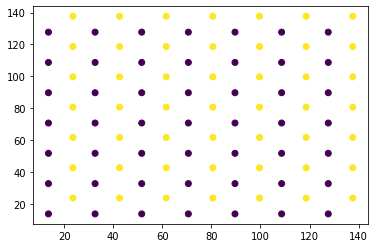

In [220]:
plt.scatter(peaks_x_fit, peaks_y_fit, c=integrated_int_truth)
# print(int_list_truth)

In [223]:
print(param)
print(sigma_x, sigma_y)

[ 1.12221629 22.01970793  5.62394765  5.67904042  2.15471786  2.13409795]
2.72 2.48


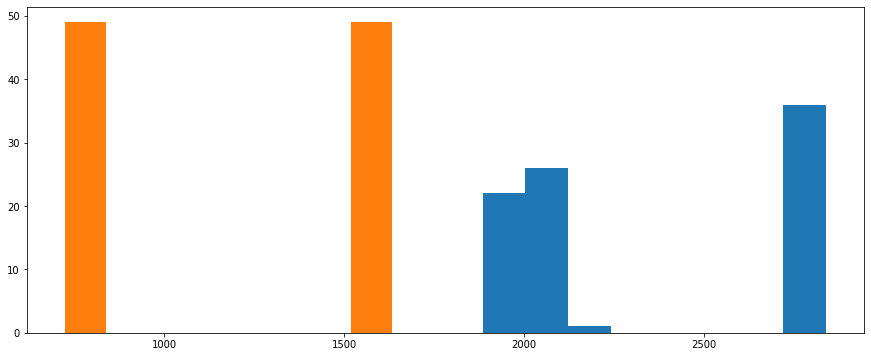

In [221]:
# Test integrated intensity between JDDC fitting and truth
fig = plt.figure(figsize=(15,6))

plt.hist(integrated_int_list, bins='auto')  # arguments are passed to np.histogram
plt.hist(integrated_int_truth, bins='auto')  # arguments are passed to np.histogram
plt.show()


## Directly visulize the 2D images

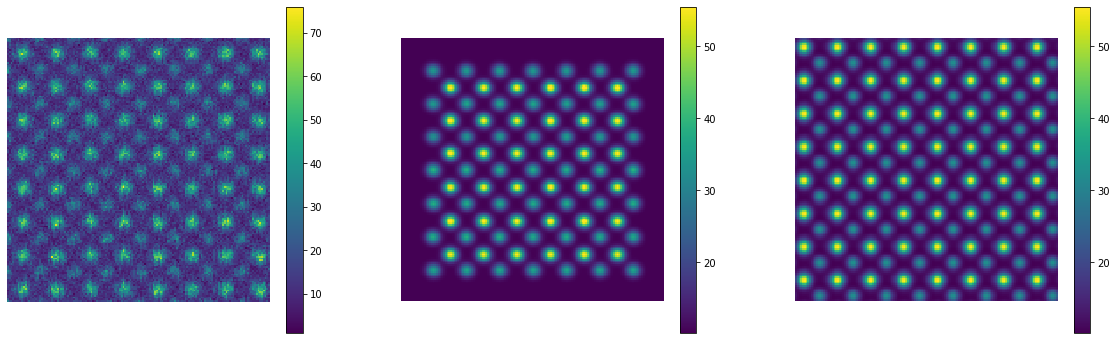

In [189]:
# Low dose case, 0.5us dwell time and 10 frames
fig = plt.figure(figsize=(20,6))

noisy = LoadQ2('E:/JDDC/DoseTest_sim/10.0us_0.25flyback/Data/STO_000_TEM.q2')
plt.subplot(131)
plt.imshow(noisy[53:53+150-1,53:52+150-1])
plt.axis('off')
plt.colorbar()

plt.subplot(133)
truth = LoadQ2('E:/JDDC/DoseTest_sim/10.0us_0.25flyback/Data/STO_truth.q2')
plt.imshow(truth[0:150,0:150])
plt.colorbar()
plt.axis('off')

plt.subplot(132)
# fitting = LoadQ2('E:/JDDC/DoseTest_sim/10.0us_0.25flyback/10Frames/10Frames_B1_results/bump_000.q2')
plt.imshow(fitting)
plt.colorbar()
plt.axis('off')
plt.clim([np.amin(truth), np.amax(truth)])


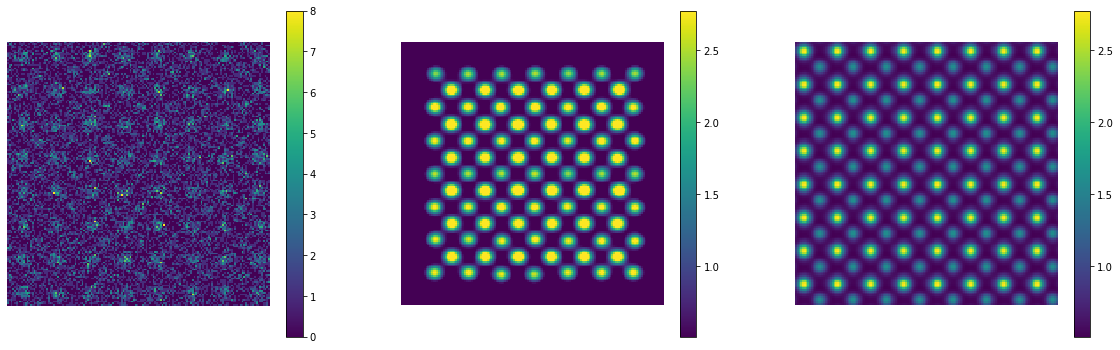

In [171]:
# Low dose case, 0.5us dwell time and 10 frames
fig = plt.figure(figsize=(20,6))

noisy = LoadQ2('E:/JDDC/DoseTest_sim/0.5us_0.5flyback_results/New_data/STO_000_TEM.q2')
plt.subplot(131)
plt.imshow(noisy[53:53+150-1,53:52+150-1])
plt.axis('off')
plt.colorbar()

plt.subplot(133)
truth = LoadQ2('E:/JDDC/DoseTest_sim/0.5us_0.5flyback_results/New_data/STO_truth.q2')
plt.imshow(truth[0:150,0:150])
plt.colorbar()
plt.axis('off')


plt.subplot(132)
# fitting = LoadQ2('E:/JDDC/DoseTest_sim/10.0us_0.25flyback/10Frames/10Frames_B1_results/bump_000.q2')
plt.imshow(fitting)
plt.colorbar()
plt.axis('off')
plt.clim([np.amin(truth), np.amax(truth)])


In [128]:
def AsyGaussian(row_size, col_size, I0, cor, sigma_x, sigma_y, c_x, c_y, A):
    img = np.zeros((row_size, col_size))
    
    def f(x, y):
        val = ((x-c_x)/sigma_x)**2 + ((y-c_y)/sigma_y)**2 - 2*cor*(x-c_x)*(y-c_y)/sigma_x/sigma_y
        val = -val/2/(1-cor**2)
        val = np.exp(val)
        val = val*A + I0
        return val
    
    for irow in range(row_size):
        for icol in range(col_size):
            img[irow,icol] = f(icol, irow)
            
    return img

In [46]:
def GaussianIntegration(I0, cor, sigma_x, sigma_y, A, N):
#     N = 5
#     I0 = -0.129
#     cor = 0.0105
#     sigma_y = 2.97
#     sigma_x = 3.38
#     A = 2.91

    def f(x, y):
        val = (x/sigma_x)**2 + (y/sigma_y)**2 - 2*cor*x*y/sigma_x/sigma_y
        val = -val/2/(1-cor**2)
        val = np.exp(val)
        val = val*A + I0
        return val

    return integrate.nquad(f, [[-N, N],[-N, N]])

In [51]:
def fitGaussianx2(data, guess, bounds):
    x = np.linspace(0, data.shape[1]-1, data.shape[1])
    y = np.linspace(0, data.shape[0]-1, data.shape[0])
    x, y = np.meshgrid(x, y)
    xdata_tuple = (x,y)
    popt, pcov = optimize.curve_fit(gaussianx2, xdata_tuple, data.ravel(), p0=guess,bounds=bounds,method='trf',verbose=0,maxfev=100000)
    return popt

In [52]:
def gaussianx2(xdata_tuple, bg ,height, center_x, center_y, width_x, width_y):

    (x, y) = xdata_tuple
    width_x = float(width_x)
    width_y = float(width_y)
    g = height*exp(
                 -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)+bg
    return g.ravel()

In [61]:
def LoadQ2(path):
    fid = open(path, mode='rt',encoding = "ISO-8859-1")
    next(fid)    # magic number P9, skip
    fid.readline()    # do not print, but read the description line
    size = fid.readline()   # image size in width, height
    width = int(size.split(' ')[0])
    height = int(size.split(' ')[1][:-1])

    # read data part in read binary mode
    img = np.zeros((height,width))
    fid = open(path, mode='rb')
    for _ in range(4):
        next(fid)
    for icol in range(width):
        for irow in range(height):
            read_bytes = fid.read(8)
            img[irow,icol] = struct.unpack('d',read_bytes)[0]
    return img